
# Facial recognition using MTCNN and ArcFace

## Face detection using MTCNN

### Module import

Let's import all the necessary module.

In [5]:
import mxnet as mx
import cv2  # For image input/output
import matplotlib.pyplot as plt # For visualization
import argparse
# cv2: opencv image processing
import cv2
import time


Validate installations.

In [6]:
print(cv2.__version__)
print(mx.__version__)



4.5.4-dev
1.8.0
4.5.4-dev
1.8.0


Now, let's import necessary functions from mxnet library.

In [7]:
# symbol: define the network structure
from core.symbol import P_Net, R_Net, O_Net

# detector: bind weight with structure and create a detector class
from core.detector import Detector

# fcn_detector: bind weight with structure and create a detector class
from core.fcn_detector import FcnDetector

# load_model: load model from .param file
from tools.load_model import load_param

# MtcnnDetector: concatenate the three networks
from core.MtcnnDetector import MtcnnDetector

Let's set the default training parameters. Let's see if we can detect face in camera.

First create the detector.

In [8]:
def get_model(prefix=['model/pnet', 'model/rnet', 'model/onet'],
              epoch=[16, 16, 16], batch_size=[2048, 256, 16], ctx=mx.cpu(0),
              thresh=[0.6, 0.6, 0.7], min_face_size=24,
              stride=2):
    # load pnet model
    args, auxs = load_param(prefix[0], epoch[0], convert=True, ctx=ctx)
    PNet = FcnDetector(P_Net("test"), ctx, args, auxs)

    # load rnet model
    args, auxs = load_param(prefix[1], epoch[0], convert=True, ctx=ctx)
    RNet = Detector(R_Net("test"), 24, batch_size[1], ctx, args, auxs)

    # load onet model
    args, auxs = load_param(prefix[2], epoch[2], convert=True, ctx=ctx)
    ONet = Detector(O_Net("test"), 48, batch_size[2], ctx, args, auxs)

    mtcnn_detector = MtcnnDetector(detectors=[PNet, RNet, ONet], ctx=ctx, min_face_size=min_face_size,
                                   stride=stride, threshold=thresh, slide_window=False)

    return mtcnn_detector

Then test it using camera

In [9]:
def test_net(prefix=['model/pnet', 'model/rnet', 'model/onet'],
             epoch=[16, 16, 16], batch_size=[2048, 256, 16], ctx=mx.cpu(0),
             thresh=[0.6, 0.6, 0.7], min_face_size=24,
             stride=2, camera_path='0'):

    mtcnn_detector = get_model(prefix, epoch, batch_size, ctx,
                               thresh, min_face_size,
                               stride)

    try:
        capture = cv2.VideoCapture(int(camera_path))
    except ValueError as e:
        capture = cv2.VideoCapture(camera_path)

    first_loop = True
    while (capture.isOpened()):
        ret, img = capture.read()
        if img is None:
            continue

        # Initialize video writing
        if (first_loop):
            first_loop = False
            fourcc = cv2.VideoWriter_fourcc(*'H264')
            h, w = img.shape[:2]
            writer = cv2.VideoWriter('test.mkv', fourcc, 10, (w, h), True)

        t1 = time.time()

        boxes, boxes_c = mtcnn_detector.detect_pnet(img)
        boxes, boxes_c = mtcnn_detector.detect_rnet(img, boxes_c)
        boxes, boxes_c = mtcnn_detector.detect_onet(img, boxes_c)

        print('shape: ', img.shape, '--', 'time: ', time.time() - t1)

        draw = img.copy()
        if boxes_c is not None:
            font = cv2.FONT_HERSHEY_SIMPLEX
            for b in boxes_c:
                cv2.rectangle(draw, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), (0, 255, 255), 1)
                cv2.putText(draw, '%.3f' % b[4], (int(b[0]), int(b[1])), font, 0.4, (255, 255, 255), 1)

        cv2.imshow("detection result", draw)
        writer.write(draw)

        k = cv2.waitKey(1)
        if k == 27 or k == 113:  # Esc or q key to stop
            writer.release()
            cv2.destroyAllWindows()
            break

Let's test it.


In [10]:
# test_net(camera_path='0', ctx=mx.cpu(0))

Let's visualize the detection in a single file.

[15:38:51] ../src/executor/graph_executor.cc:1995: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:1995: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.
[15:38:51] ../src/executor/graph_executor.cc:2076: Subgraph backend MKLDNN is activated.


(-0.5, 639.5, 479.5, -0.5)

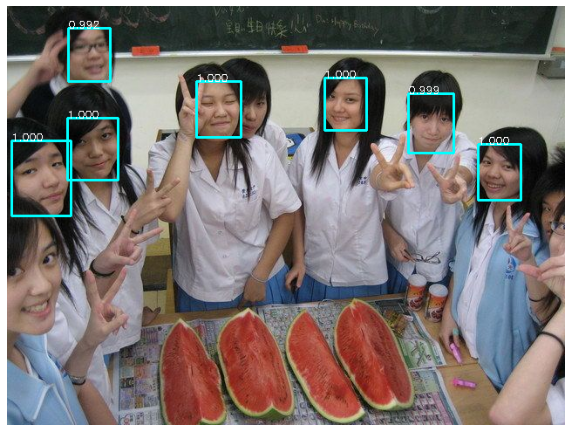

In [13]:
detector = get_model()
img = cv2.cvtColor(cv2.imread("test01.jpg"), cv2.COLOR_BGR2RGB)

font = cv2.FONT_HERSHEY_SIMPLEX

boxes, boxes_c = detector.detect_pnet(img)
boxes, boxes_c = detector.detect_rnet(img, boxes_c)
boxes, boxes_c = detector.detect_onet(img, boxes_c)

draw = img.copy()
if boxes_c is not None:
    for b in boxes_c:
        cv2.rectangle(draw, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), (0, 255, 255), 2)
        cv2.putText(draw, '%.3f' % b[4], (int(b[0]), int(b[1])), font, 0.4, (255, 255, 255), 1)
plt.figure(figsize = (10,10))
plt.imshow(draw)
plt.axis('off')